In [58]:
import os
import torch
from mlp_mixer_pytorch import MLPMixer
import numpy as np
import cv2
import tqdm as notebook_tqdm
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import scipy.io
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from keras.layers import *
from keras.models import Model
from torchvision import transforms
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve

In [59]:
def transform_mat (path):
    data = scipy.io.loadmat(path)
    eog = np.array(data['eog'])
    fpz = np.array(data['fpz'])
    pz = np.array(data['pz'])
    image_np = np.stack((eog, pz, fpz), axis=-1)
    # tensor_array = torch.tensor(image_np)
    return image_np


In [114]:
path = '/Users/arpanmukhopadhyay/Documents/EEG topics/sleep-edfx-toolbox-master/markers'

def load_data(path, split=0.15):
    images = shuffle(glob(os.path.join(path, "*", "*.mat")))
    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    return train_x, valid_x, test_x

train_x, valid_x, test_x = load_data(path)


In [115]:
def ReturnClassCount(data):
    class_count = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0}
    for ind in range(0,len(data)):
        class_count[data[ind].split("/")[-2]] += 1
    return class_count

print(ReturnClassCount(train_x))
print(ReturnClassCount(test_x))
print(ReturnClassCount(valid_x))

{'0': 4892, '1': 4910, '2': 4817, '3': 4983, '4': 4851, '5': 4943}
{'0': 1055, '1': 1055, '2': 1103, '3': 979, '4': 1101, '5': 1006}
{'0': 1052, '1': 1034, '2': 1079, '3': 1037, '4': 1047, '5': 1050}


In [116]:
train_y = []
valid_y = []
test_y = []

def change(arr,labels):
    for i in range(len(arr)):
        labels.append(int(arr[i].split("/")[-2]))
        arr[i] = transform_mat(arr[i])

change(valid_x,valid_y)
change(test_x,test_y)
change(train_x,train_y)
train_x = np.array(train_x)
test_x = np.array(test_x)
valid_x = np.array(valid_x)

print(len(train_x))
print(len(valid_x))
print(len(test_x))

29396
6299
6299


In [117]:
train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
train_x_tensor = train_x_tensor.permute(0, 3, 1, 2)

train_y_tensor = torch.tensor(train_y)

test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
test_x_tensor = test_x_tensor.permute(0, 3, 1, 2)

test_y_tensor = torch.tensor(test_y)

valid_x_tensor = torch.tensor(valid_x, dtype=torch.float32)
valid_x_tensor = valid_x_tensor.permute(0, 3, 1, 2)

valid_y_tensor = torch.tensor(valid_y)

In [118]:
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(valid_x_tensor, valid_y_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32)

test_dataset = TensorDataset(test_x_tensor, test_y_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [119]:
model = MLPMixer(
    image_size = (50, 60),
    channels = 3,
    patch_size = 5,
    dim = 512,
    depth = 12,
    num_classes = 6
)

In [105]:
def summary(model, input_size):
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_params += param.numel()
    print(f"Trainable parameters: {total_params}")

    print("Layer-wise summary:")
    print("===================")
    for name, module in model.named_modules():
        if isinstance(module, nn.Sequential):
            continue
        if isinstance(module, nn.Module):
            num_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
            print(f"{name}: {module.__class__.__name__}")
            print(f"Number of parameters: {num_params}")
            print(module)
            
input_size = (1, 784)  # Example input size
summary(model, input_size)

Trainable parameters: 4612134
Layer-wise summary:
0: Rearrange
Number of parameters: 0
Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=5, p2=5)
1: Linear
Number of parameters: 38912
Linear(in_features=75, out_features=512, bias=True)
2.0: PreNormResidual
Number of parameters: 116824
PreNormResidual(
  (fn): Sequential(
    (0): Conv1d(120, 480, kernel_size=(1,), stride=(1,))
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Conv1d(480, 120, kernel_size=(1,), stride=(1,))
    (4): Dropout(p=0.0, inplace=False)
  )
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)
2.0.fn.0: Conv1d
Number of parameters: 58080
Conv1d(120, 480, kernel_size=(1,), stride=(1,))
2.0.fn.1: GELU
Number of parameters: 0
GELU(approximate='none')
2.0.fn.2: Dropout
Number of parameters: 0
Dropout(p=0.0, inplace=False)
2.0.fn.3: Conv1d
Number of parameters: 57720
Conv1d(480, 120, kernel_size=(1,), stride=(1,))
2.0.fn.4: Dropout
Number of parameters: 0
Dropout(p=0.

In [120]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [121]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [123]:
num_epochs = 5
for epoch in range(num_epochs):
    print(epoch)
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_predicted_labels = []
    train_true_labels = []
    progress_train = len(train_dataloader)
    
    for inputs, labels in train_dataloader:
        progress_train -= 1
        if progress_train % 100 == 0:
            print(progress_train)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, dim=1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        train_predicted_labels.extend(predicted.tolist())
        train_true_labels.extend(labels.tolist())
    
    train_loss /= len(train_dataloader.dataset)
    train_accuracy = train_correct / len(train_dataloader.dataset)
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predicted_labels = []
    val_true_labels = []
    
    with torch.no_grad():
        progress_val = len(val_dataloader)
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            progress_val -= 1
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
            val_predicted_labels.extend(val_predicted.tolist())
            val_true_labels.extend(val_labels.tolist())   
            
        val_average_loss = val_loss / len(val_dataloader)
        val_accuracy = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_average_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_average_loss)
    val_accuracies.append(val_accuracy)
    
    train_predicted_labels = np.array(train_predicted_labels)
    train_true_labels = np.array(train_true_labels)
    val_predicted_labels = np.array(val_predicted_labels)
    val_true_labels = np.array(val_true_labels)

    # Compute classification report for training set
    train_report = classification_report(train_true_labels, train_predicted_labels)
    print("Train Classification Report:")
    print(train_report)
# 
    # Compute classification report for validation set
    val_report = classification_report(val_true_labels, val_predicted_labels)
    print("Validation Classification Report:")
    print(val_report)

0


KeyboardInterrupt: 

In [113]:
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
progress_train = len(test_dataloader)
with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        progress_train -= 1
        test_outputs = model(test_inputs)
        if progress_train % 50 == 0:
            print(progress_train)
        test_loss += criterion(test_outputs, test_labels).item()

        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

test_average_loss = test_loss / len(test_dataloader)
test_accuracy = 100 * test_correct / test_total

print(f"Test Loss: {test_average_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


100
50
0
Test Loss: 0.7387, Test Accuracy: 75.09%


[0.2265811965811966, 0.2922222222222222, 0.35786324786324786, 0.4043589743589744, 0.44333333333333336, 0.47136752136752136, 0.4946153846153847, 0.5110256410256411]
[0.2265811965811966, 0.2922222222222222, 0.35786324786324786, 0.4043589743589744, 0.44333333333333336, 0.47136752136752136, 0.4946153846153847, 0.5110256410256411]


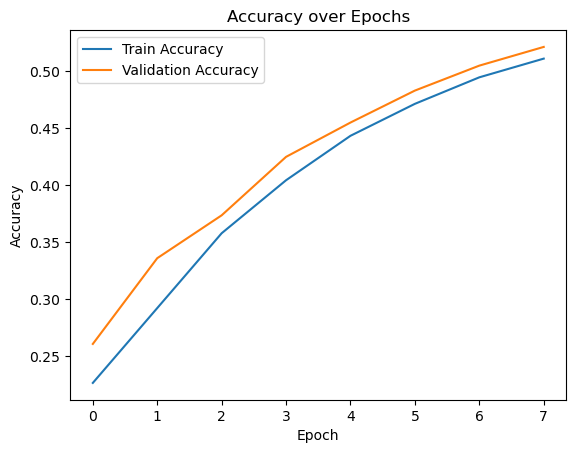

In [91]:
plt.plot(train_accuracies[:8], label='Train Accuracy')
plt.plot(val_accuracies[:8], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

[0.9415566005271337, 0.7717724601659538, 0.7054610932380021, 0.6521031403274732, 0.5940776842309543, 0.5336029114028019, 0.4814125586228791, 0.4097472942184871]


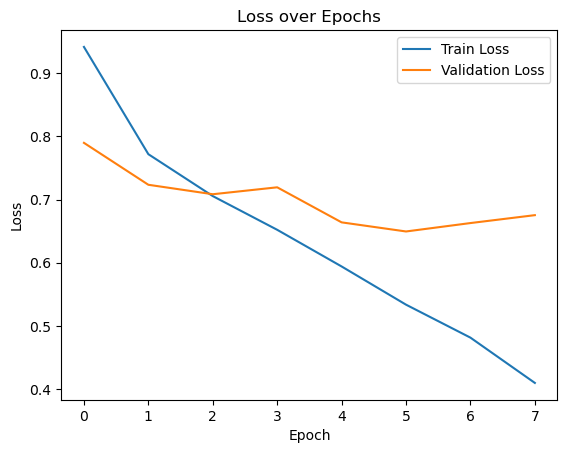

In [92]:
plt.plot(train_losses[:8], label='Train Loss')
plt.plot(val_losses[:8], label='Validation Loss')
print(train_losses[:8])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

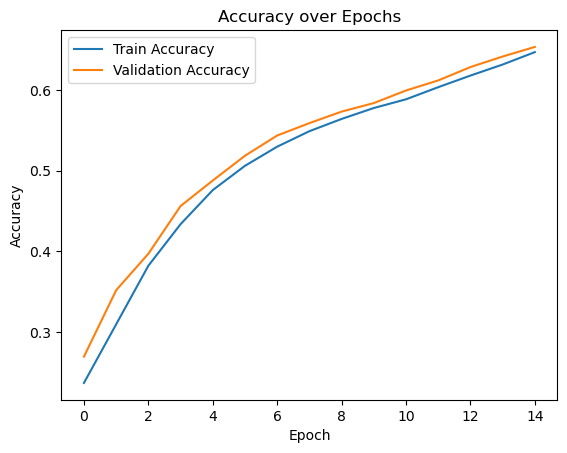

In [19]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


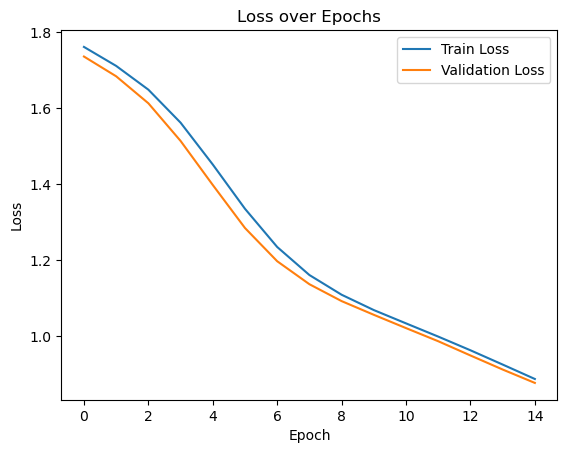

In [20]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [106]:
train_accuracies = [0.2265811965811966, 0.2922222222222222, 0.35786324786324786, 0.4043589743589744, 0.44333333333333336, 0.47136752136752136, 0.4946153846153847, 0.5110256410256411, 0.5260683760683761, 0.5383760683760684, 0.5486324786324787, 0.5609401709401709, 0.5732478632478633, 0.5869230769230769, 0.5985470085470086, 0.6404583879033218, 0.6788308131920466, 0.7081795451839504, 0.7312180021431123, 0.7574413620669127, 0.7810751279914275, 0.805333968329563, 0.8327777116323372]

In [84]:
print(len(train_accuracies))

23


In [110]:
val_accuracies = [0.26076923076923075, 0.335982905982906, 0.3735897435897436, 0.4248717948717949, 0.45495726495726496, 0.48299145299145296, 0.5048717948717949, 0.5212820512820513, 0.5342735042735043, 0.5452136752136753, 0.5568376068376069, 0.5698290598290598, 0.5828205128205128, 0.5958119658119658, 0.6074358974358974,0.6573041200285782, 0.7044534412955465, 0.695879971421767, 0.7044534412955465, 0.7394617766134794, 0.7320790664443915, 0.7477970945463206, 0.7456537270778757]

In [111]:
print(len(val_accuracies))

23


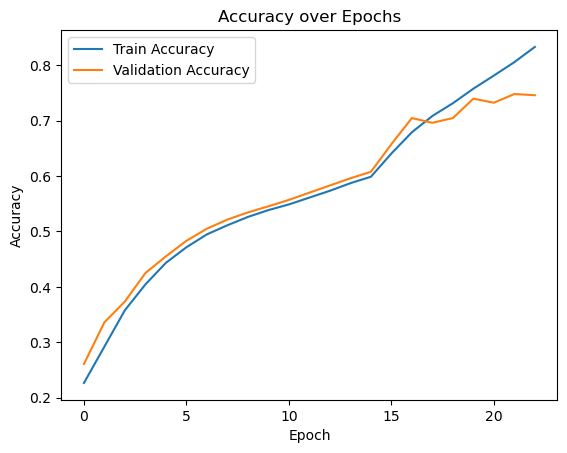

In [112]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [99]:
train_loss = [1.7635643564356436, 1.7112871287128715, 1.6510891089108912, 1.5592079207920793, 1.4483168316831683, 1.3342574257425743, 1.2328712871287129, 1.1584158415841583, 1.1093069306930694, 1.064950495049505, 1.0332673267326733, 0.9968316831683168, 0.9603960396039604, 0.9255445544554455, 0.8875247524752475,0.8415566005271337, 0.7717724601659538, 0.7054610932380021, 0.6521031403274732, 0.5940776842309543, 0.5336029114028019, 0.4814125586228791, 0.4097472942184871]
validation_loss = [1.7366336633663368, 1.682772277227723, 1.6146534653465348, 1.5132673267326733, 1.396039603960396, 1.28990099009901, 1.1948514851485148, 1.1346534653465348, 1.0902970297029704, 1.0554455445544555, 1.0205940594059406, 0.9857425742574257, 0.9461386138613861, 0.9097029702970297, 0.8748514851485149, 0.8097240962042953, 0.723369485501087, 0.7083890905434435, 0.7193529111417857, 0.663879385274468, 0.6494554513783166, 0.6627734226710869, 0.6752818048451886]


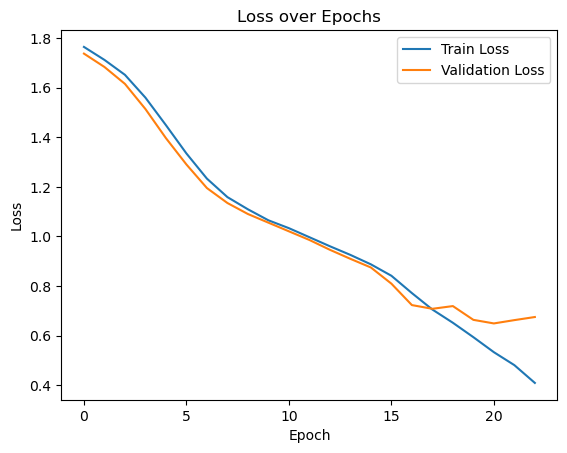

In [100]:
plt.plot(train_loss, label='Train Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()